In [268]:
from Bio.Cluster import kcluster
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import os

In [233]:
### Analysis input
input="XBB15-LCB1"
input_dataframe=pd.read_csv(f"output/{input}/opt_binders/filtered_binders.csv")

os.makedirs(f"output/{input}/filtered_sequences/filtered_binders")
input_dataframe.describe()

,score,plddt,i_ptm,i_pae,rmsd,ddg,rg,charge,sap,dG,dSASA,dG_dSASA_ratio,int_unsat_hbonds,int_hbonds,hyd_contacts,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.826036,0.955420,0.901549,3.943733,0.146916,-51.231841,10.040948,-3.655313,25.629001,67.423314,1650.549033,3.949831,10.810976,6.743902,7.036585,0.678313,-36.422164,-3.106970,-2.221277
std,0.039941,0.000811,0.005787,0.067221,0.051442,2.054586,0.030379,1.058477,5.482801,69.000298,82.246273,4.098190,3.946840,1.592243,0.244955,0.015785,5.087742,0.099030,0.389938
min,0.730676,0.954476,0.888785,3.822869,0.052879,-54.357000,9.960623,-6.800058,17.582819,-23.196578,1231.566345,-1.519539,3.000000,1.000000,7.000000,0.637880,-49.238138,-3.672559,-3.140232
25%,0.798263,0.954810,0.895682,3.910507,0.110071,-52.964750,10.014651,-4.757677,20.690872,-3.988860,1591.412872,-0.246005,8.000000,5.000000,7.000000,0.668589,-39.770990,-3.126144,-2.497758
50%,0.824682,0.955170,0.904840,3.944346,0.139946,-52.199500,10.031329,-3.701676,23.650586,78.631304,1696.164010,4.596325,12.000000,7.000000,7.000000,0.676787,-35.319272,-3.089311,-2.088624
75%,0.855757,0.955790,0.906909,3.966463,0.178190,-49.412000,10.072030,-2.767276,30.991885,116.188504,1716.538268,6.771054,14.000000,8.000000,7.000000,0.683489,-32.830431,-3.050420,-1.926683
max,0.950638,0.957900,0.911125,4.429562,0.341782,-45.230000,10.089997,-2.682179,36.945316,304.327951,1745.231987,18.433581,19.000000,9.000000,9.000000,0.726146,-23.811998,-3.000509,-1.396189


## Filter dataframe
tipical metrics:
- plddt > 0.85-0.9
- i_pae < 5
- ddg_dsasa_100 < -2.5 - -3.5 (sort by)
additional metrics:
- charge < -2
- hyd_contacts > 4-6
- sap < 30-60

In [244]:
filtered = input_dataframe[(input_dataframe["plddt"]>0.90)&
                           (input_dataframe["ddg"]<-30)&
                           (input_dataframe["charge"]<-2)&
                           (input_dataframe["ddg_dsasa_100"]<-2.5)&
                           #(input_dataframe["ddgscore_dsasa_100"]<-2.5)&
                           (input_dataframe["shape_comp"]>0.62)&
                           (input_dataframe["hyd_contacts"]>6)&
                           (input_dataframe["sap"]<40)]#&
                           #(input_dataframe["dG"]<30)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv", index=False)
filtered

,score,plddt,i_ptm,i_pae,rmsd,model_path,input_pdb,ddg,rg,charge,...,dSASA,dG_dSASA_ratio,int_unsat_hbonds,int_hbonds,hyd_contacts,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,seq
0,0.766746,0.955639,0.888785,4.376522,0.199316,output/XBB15-LCB1/opt_binders/binders/579_470/...,output/XBB15-LCB1/opt_binders/binders/579_470/...,-45.230,10.023927,-2.716361,...,1231.566345,1.525011,10.0,1.0,9.0,0.707727,-36.598774,-3.672559,-2.971726,SPFARAVEIHRRAMELYKEGKKEEANKVFELLREWAKTKDESLLDE...
1,0.785096,0.954575,0.889905,4.429562,0.216167,output/XBB15-LCB1/opt_binders/binders/579_470/...,output/XBB15-LCB1/opt_binders/binders/579_470/...,-46.007,10.036078,-3.717047,...,1258.483147,0.203190,11.0,1.0,9.0,0.726146,-36.819847,-3.655750,-2.925732,SPFARAVEIHKRAMELYKKGKKEEAEKVFELLREWAKTKNEELLDE...
2,0.812374,0.954649,0.894636,4.008572,0.086369,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-52.574,10.067076,-4.762486,...,1540.575276,-0.521886,5.0,8.0,7.0,0.676264,-42.909874,-3.412621,-2.785315,SSLDRLNKIVAEAKELETLGKFEESLEVYDLIGKYLNTKDEKYLDE...
3,0.745213,0.955274,0.895376,3.957288,0.104024,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.186,10.077020,-2.772061,...,1515.589685,-0.729657,4.0,9.0,7.0,0.681681,-43.755070,-3.377299,-2.887000,SDLDRLNKIVKEAKELETLGKYEESLEVYDLIGKYLNTKDKKYLDE...
4,0.795052,0.955477,0.895440,3.992614,0.106472,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.736,10.078912,-2.768882,...,1546.347072,-1.320101,4.0,9.0,7.0,0.670714,-45.126033,-3.345691,-2.918234,SDLERLNKIVKEAKELETLGKFEESLEVYDLIGKYLNTKDKKYLDE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.797686,0.955196,0.895754,3.965950,0.086379,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-47.658,10.077405,-4.769109,...,1585.979148,-0.494048,4.0,9.0,7.0,0.702933,-46.986712,-3.004958,-2.962631,SDLDRLNKIVKEAEELKTLGKYEESLDVYDLIGEYLNTKDKKYLDE...
160,0.826284,0.954879,0.899444,3.875973,0.211538,output/XBB15-LCB1/opt_binders/binders/976_304/...,output/XBB15-LCB1/opt_binders/binders/976_304/...,-48.283,10.034939,-3.755176,...,1607.590893,1.195900,18.0,5.0,7.0,0.675635,-40.154567,-3.003438,-2.497810,SSLERANRLVAEADALAAEGKFEAALDIKELVGLYFNTKDESYLKQ...
161,0.876326,0.955508,0.896881,3.956453,0.341782,output/XBB15-LCB1/opt_binders/binders/976_304/...,output/XBB15-LCB1/opt_binders/binders/976_304/...,-48.452,10.056201,-3.762511,...,1614.080291,0.655237,15.0,5.0,7.0,0.668648,-33.356205,-3.001833,-2.066577,SNLDRANRLVEEADKLEKQGKWEEALDIKELVGLYYNTKDESYLTK...
162,0.769324,0.955102,0.895309,3.941662,0.231736,output/XBB15-LCB1/opt_binders/binders/976_304/...,output/XBB15-LCB1/opt_binders/binders/976_304/...,-48.580,10.078514,-4.767061,...,1618.360753,0.130637,10.0,5.0,7.0,0.658425,-36.048491,-3.001803,-2.227469,SDLDKANELVKEAEELEKEGKYEEALEIKELVGLYFNTKDKSYLTK...


In [210]:
## Analyze with Colabfold2 and Rosettafold2 and ESMfold?

# input pdbs? or prepare a3m files?

In [ ]:
# copy best pdbs to the filtered_binders folder

# add model ids and model names to the dataframe

# Cluster sequences

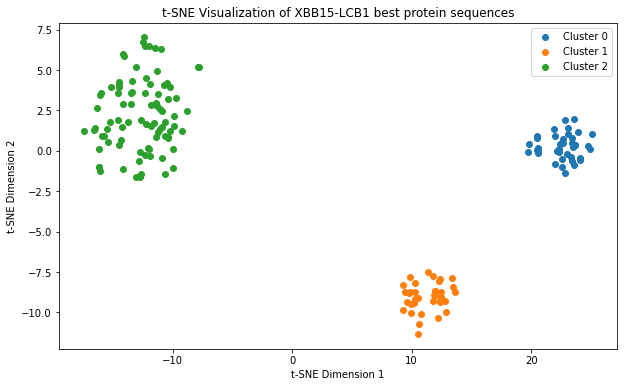

Cluster 0: 40 sequences
Cluster 1: 37 sequences
Cluster 2: 87 sequences


,score,plddt,i_ptm,i_pae,rmsd,ddg,rg,charge,sap,dG,dSASA,dG_dSASA_ratio,int_unsat_hbonds,int_hbonds,hyd_contacts,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100
clusterid,,,,,,,,,,,,,,,,,,,
0,0.791868,0.955429,0.895030,3.978387,0.132079,-49.470250,10.076443,-4.069042,32.632852,-12.440671,1561.283887,-0.798800,4.950000,8.800000,7.000000,0.695437,-41.304061,-3.169722,-2.644672
1,0.817277,0.955208,0.897048,3.905669,0.196014,-49.451459,10.061900,-4.144728,28.983367,50.532572,1618.022658,3.106158,12.945946,5.027027,7.054054,0.664550,-38.559688,-3.056335,-2.384960
2,0.845471,0.955506,0.906460,3.943987,0.132856,-52.798943,10.015717,-3.256951,20.982269,111.325807,1705.423536,6.491913,12.597701,6.528736,7.045977,0.676293,-33.268552,-3.099654,-1.957000


In [246]:

num_clusters=3


matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in filtered["seq"].to_list()])
clusterid, error, nfound = kcluster(matrix, nclusters=num_clusters)

# Apply t-SNE to the matrix to reduce the dimensionality and visualize the sequences.
tsne = TSNE(n_components=2, random_state=42)
embedded_matrix = tsne.fit_transform(matrix)

# Create a scatter plot of the embedded points and label them with cluster IDs.
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = embedded_matrix[clusterid == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title(f"t-SNE Visualization of {input} best protein sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.savefig(f"output/{input}/filtered_sequences/tsne_binders.png")
plt.show()


# Print the number of sequences in each cluster.
cluster_counts = Counter(clusterid)
sorted_cluster_counts = dict(sorted(cluster_counts.items()))
for cluster, count in sorted_cluster_counts.items():
    print(f"Cluster {cluster}: {count} sequences")

# Add cluster id to dataframe
filtered["clusterid"]=clusterid
filtered.to_csv(f"output/{input}/filtered_sequences/1_filtered_binders_clus.csv", index=False)

# Calculate average cluster metrics
average_metrics_by_cluster = filtered.groupby('clusterid').mean()
average_metrics_by_cluster.to_csv(f"output/{input}/filtered_sequences/1_cluster_average.csv", index=False)
average_metrics_by_cluster

# Output final dataframe and binders

In [266]:
# Select number of final sequences and cluster ratios
total_numbers=[12, 24, 48, 96, 192]
cluster_ratios = [0.25, 0.25, 0.5]

# Function to calculate the number of sequences for each cluster based on the given ratios
def calculate_sequences_ratios(total_sequences, cluster_ratios):
    cluster_sequences = {}
    total_ratio = sum(cluster_ratios)
    remaining_sequences = total_sequences

    for i, ratio in enumerate(cluster_ratios):
        if i == len(cluster_ratios) - 1:
            cluster_sequences[i] = remaining_sequences
        else:
            sequences_for_cluster = int(total_sequences * ratio / total_ratio)
            cluster_sequences[i] = sequences_for_cluster
            remaining_sequences -= sequences_for_cluster

    return cluster_sequences

In [272]:

for total_sequences in total_numbers:
    # Calculate the number of sequences for each cluster
    cluster_sequences = calculate_sequences_ratios(total_sequences, cluster_ratios)
    print(f"Total Sequences: {total_sequences}")
    print(cluster_sequences)

    # Create a new dataframe with the final number of sequences for each cluster
    final_sequences = []
    for cluster_id, num_sequences in cluster_sequences.items():
        cluster_data = filtered[filtered['clusterid'] == cluster_id].iloc[:num_sequences]
        final_sequences.append(cluster_data)

    final_dataframe = pd.concat(final_sequences)

    # Save the dataframe to a CSV file
    binder_pdbs_path=f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/binder_{total_sequences}_pdbs"
    os.makedirs(binder_pdbs_path, exist_ok=True)
    filename = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/final_binders_{total_sequences}.csv"
    final_dataframe.to_csv(filename, index=False)

    for _, row in final_dataframe.iterrows():
        pdb_path = row["model_path"]
        if os.path.exists(pdb_path) and os.path.isfile(pdb_path):
            pdb_filename = os.path.basename(pdb_path)
            destination_path = os.path.join(binder_pdbs_path, pdb_filename)
            shutil.copy(pdb_path, destination_path)
            #print(f"Copied {pdb_filename} to {destination_path}")
        else:
            print(f"File not found: {pdb_path}")

    print(f"DataFrame for {total_sequences} sequences saved to {filename}")

Total Sequences: 12
{0: 3, 1: 3, 2: 6}
DataFrame for 12 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_12/final_binders_12.csv
Total Sequences: 24
{0: 6, 1: 6, 2: 12}
DataFrame for 24 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_24/final_binders_24.csv
Total Sequences: 48
{0: 12, 1: 12, 2: 24}
DataFrame for 48 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_48/final_binders_48.csv
Total Sequences: 96
{0: 24, 1: 24, 2: 48}
DataFrame for 96 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_96/final_binders_96.csv
Total Sequences: 192
{0: 48, 1: 48, 2: 96}
DataFrame for 192 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_192/final_binders_192.csv
